# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var

# preprocess

In [145]:
import os
import pandas as pd

train_data_path ="data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [46]:
train_data.groupby('class').count()

,idx,conversation
class,,
갈취 대화,981,981
기타 괴롭힘 대화,1094,1094
직장 내 괴롭힘 대화,979,979
협박 대화,896,896


In [47]:
train_data[train_data.iloc[392]['conversation'] == train_data['conversation']]

,idx,class,conversation
29,29,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
392,392,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...


In [48]:
train_data.duplicated('conversation').sum()

104

In [146]:
train_data = train_data.drop_duplicates(subset='conversation')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3846 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3846 non-null   int64 
 1   class         3846 non-null   object
 2   conversation  3846 non-null   object
dtypes: int64(1), object(2)
memory usage: 120.2+ KB


In [50]:
train_data.groupby('class').count()

,idx,conversation
class,,
갈취 대화,973,973
기타 괴롭힘 대화,1011,1011
직장 내 괴롭힘 대화,970,970
협박 대화,892,892


In [51]:
train_data.iloc[29,2]

'병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 되지 너 공부 개못하는 찐따잖아.\n야 닭대가리가 말도 하네 동물농장 나가자.\n너네 학교폭력으로 신고하기 전에 그만 해.\n아이고 무서워라 살려주세요 으헝헝\n제발 좀 저리 가.\n나였으면 아이스크림 먹을 시간에 공부한다.\n멈춰!\n저러니까 쳐맞고 다니지'

In [52]:
import re

def preprocess_document(document):
    document = re.sub('[^ㄱ-ㅎ가-힣a-zA-Z0-9]', ' ', document)
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document

In [53]:
preprocess_document(train_data.iloc[29,2])

'병신이 아이스크림 먹게 돼 있냐 난 먹으면 안 돼 그만 좀 해 당연히 안 되지 너 공부 개못하는 찐따잖아 야 닭대가리가 말도 하네 동물농장 나가자 너네 학교폭력으로 신고하기 전에 그만 해 아이고 무서워라 살려주세요 으헝헝 제발 좀 저리 가 나였으면 아이스크림 먹을 시간에 공부한다 멈춰 저러니까 쳐맞고 다니지'

### mecab

In [54]:
from konlpy.tag import Mecab

mecab = Mecab()

In [70]:
def get_tokens(tokenizer, token_pos, text):
    token_list = tokenizer.pos(text)
    tokens = []
    for word in token_list:
        if word[1] in token_pos:
            tokens.append((word[0]))
    return tokens

In [90]:
def get_tokens_corpus(corpus, pos):
    tokenizer = Mecab()
    corpus_tokens = []
    for sentence in corpus:
        tokens = get_tokens(
            tokenizer, pos, sentence)
        corpus_tokens.append(tokens)
    return corpus_tokens

In [147]:
import random
rand_index = random.randint(0, train_data.shape[0])

text_sample = train_data['conversation'].iloc[rand_index]

print(f"{text_sample} - {train_data['class'].iloc[rand_index]}")
print(mecab.pos(text_sample))

저기요 혹시 우동 주문부탁 드려도 되나요?
우동이요.? 저희 가게 메뉴에는 없는건데요.
아 네 알아요. 근데 저희 애가 어린데 막창덮밥 같이 먹자고 할 수는 없잖아요. 우동 끓이기도 쉽고 돈은 낼게요.
저희 메뉴에 없는 메뉴라 주문이 불가하세요. 재료도 준비 되어있지도 않고요.
무슨 가게 서비스가 이래? 우동 하나가 그렇게 어려워요? 제가 돈을 안 낸다 한것도 아니고 낸다고요.
손님 제가 재료가 있으면 어느정도 해드렸죠. 근데 재료도 없지 않습니까 애초에 없는 메뉴를 주문하시는 게 잘못된 행동입니다.
니가 뭔데 내 잘잘못을 따져? 너 내가 맘카페 우수회원이야. 여기 어린 아이들 밥 먹는거 거부한다고 올려버릴거야.
기분 나쁘셨다면 죄송합니다. 하지만 손님 메뉴판에 없는 음식을 주문하는건 저희가 감당이 불가능해서 어렵다는 말씀 드립니다.
그냥 못 한다고 하세요. 냉동된거 사다 파니까 그런 기본적인 음식도 못 만드나보지. 돼지 파니까 내가 아주 개돼지로 보이지? 애초에 식당에 어른메뉴만 있는거부터 배려심 떨어지는거야. 그럼 애들은 뭐 먹으라고 우리같은 애 있는 부부는 밖에서 먹지도 마?
그게 아니고요. 하. 죄송합니다. - 기타 괴롭힘 대화
[('저기', 'NP'), ('요', 'JX'), ('혹시', 'MAG'), ('우동', 'NNG'), ('주문', 'NNG'), ('부탁', 'NNG'), ('드려도', 'VV+EC'), ('되', 'VV'), ('나요', 'EF'), ('?', 'SF'), ('우동', 'NNG'), ('이', 'VCP'), ('요', 'EF'), ('.', 'SF'), ('?', 'SY'), ('저희', 'NP'), ('가', 'VV'), ('게', 'EC'), ('메뉴', 'NNG'), ('에', 'JKB'), ('는', 'JX'), ('없', 'VA'), ('는', 'ETM'), ('건데요', 'NNB+VCP+EF'), ('.', 'SF'), ('아', 'IC'), ('네', 'IC'), ('알', 'VV'), ('아요', 'EF'), 

In [148]:
pos = ['VV', 'VV+EC', 'VV+EF', 'NNG', 'NP', 'MAG']
sample_tokens = get_tokens(mecab, pos, text_sample)
print(sample_tokens)

['저기', '혹시', '우동', '주문', '부탁', '드려도', '되', '우동', '저희', '가', '메뉴', '알', '저희', '애', '막창', '덮밥', '같이', '먹', '우동', '끓이', '돈', '낼게요', '저희', '메뉴', '메뉴', '주문', '불가', '재료', '준비', '되', '가게', '서비스', '이래', '우동', '그렇게', '제', '돈', '안', '낸다', '손', '제', '재료', '정도', '해', '재료', '애초', '메뉴', '주문', '잘못', '행동', '니', '잘잘못', '따져', '너', '내', '맘', '카페', '우수', '회원', '여기', '아이', '밥', '먹', '거부', '올려', '기분', '손님', '메뉴판', '음식', '주문', '저희', '감당', '가능', '말씀', '드립니다', '그냥', '못', '한다고', '냉동', '사', '파', '기본', '음식', '못', '만드', '돼지', '파', '내', '아주', '개돼지', '보이', '애초', '식당', '어른', '메뉴', '배려', '떨어지', '애', '먹', '우리', '애', '있', '부부', '밖', '먹']


In [91]:
train_data.loc[:, "token_pos"] = get_tokens_corpus(train_data["conversation"], pos)

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [92]:
train_data["token_pos"].head()

0    [지금, 너, 스스로, 죽여, 애원, 죽, 혼자, 죽, 우리, 사건, 휘말리, 진짜...
1    [길동, 경찰서, 마트, 폭발물, 설치, 똑바로, 들, 더, 얘기, 장난, 전화, ...
2    [너, 되게, 알, 나, 남자, 첨, 그만, 해, 니, 놀리, 너, 키, 재, 안,...
3    [거기, 너, 말, 너, 이리, 오, 일, 너, 옷, 보인다, 돈, 좀, 돈, 뒤져...
4    [저기, 혹시, 날, 너무, 저희, 회사, 선크림, 파, 손등, 발라, 진짜, 안,...
Name: token_pos, dtype: object

In [149]:
class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

train_data = train_data[['class', 'conversation']]
train_data['class'] = train_data['class'].map(lambda c: class_names.index(c))

train_data.head()

,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [75]:
def dummy_func(data):
    return data

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vector = TfidfVectorizer(preprocessor=preprocess_document, tokenizer=mecab.morphs)
vector = TfidfVectorizer(preprocessor=dummy_func, tokenizer=dummy_func)
# print(vector.fit_transform(train_data['conversation']).toarray())
vector.fit_transform(train_data['token_pos'])

<3846x8910 sparse matrix of type '<class 'numpy.float64'>'
	with 123210 stored elements in Compressed Sparse Row format>

In [107]:
print(vector.vocabulary_)

{'지금': 7150, '너': 1500, '스스로': 4758, '죽여': 7048, '애원': 5296, '죽': 7047, '혼자': 8711, '우리': 5887, '사건': 4062, '휘말리': 8840, '진짜': 7285, '정말': 6799, '잘못': 6518, '선택': 4393, '가족': 78, '못': 2996, '한다면': 8451, '모조리': 2945, '하': 8368, '도와': 2030, '그냥': 850, '다': 1705, '이': 6142, '제발': 6857, '길동': 1078, '경찰서': 444, '마트': 2649, '폭발물': 8280, '설치': 4413, '똑바로': 2470, '들': 2279, '더': 1949, '얘기': 5356, '장난': 6555, '전화': 6734, '걸': 338, '마시': 2621, '터지': 8012, '업무': 5477, '방해죄': 3379, '해당': 8538, '판단': 8175, '달려': 1808, '꽤': 1221, '선생': 4381, '진정': 7281, '이야기': 6213, '경고': 419, '말': 2702, '되게': 2157, '알': 5234, '나': 1286, '남자': 1394, '첨': 7595, '그만': 894, '해': 8532, '니': 1697, '놀리': 1593, '키': 7927, '재': 6591, '안': 5198, '돼': 2144, '군대': 784, '가': 0, '보태': 3608, '난쟁이': 1365, '장가가': 6551, '희망': 8893, '가져': 62, '이상': 6206, '수술': 4668, '엄마': 5470, '그거': 843, '나람': 1306, '어찌': 5417, '살': 4190, '괴롭히': 680, '거기': 280, '이리': 6184, '오': 5677, '일': 6315, '옷': 5772, '보인다': 3597, '돈': 2059, '좀': 6952, '뒤져서': 22

In [94]:
from sklearn.model_selection import train_test_split

x_train = vector.transform(train_data['conversation'])
y_train = train_data['class']

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [95]:
print('train size:', x_train.shape[0])
print('validation size:', x_val.shape[0])

train size: 3076
validation size: 770


# model: cnb

In [96]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(x_train, y_train)

ComplementNB()

In [ ]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_train, model.predict(x_train), zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       713
           1       0.92      0.97      0.94       784
           2       0.93      0.99      0.96       768
           3       0.98      0.89      0.93       811

    accuracy                           0.95      3076
   macro avg       0.95      0.95      0.95      3076
weighted avg       0.95      0.95      0.95      3076



In [97]:
print(classification_report(y_train, model.predict(x_train), zero_division=0))

              precision    recall  f1-score   support

       갈취 대화       0.77      0.84      0.80       794
   기타 괴롭힘 대화       0.86      0.65      0.74       790
 직장 내 괴롭힘 대화       0.67      0.97      0.79       772
       협박 대화       0.90      0.62      0.74       720

    accuracy                           0.77      3076
   macro avg       0.80      0.77      0.77      3076
weighted avg       0.80      0.77      0.77      3076



### visualize

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 

In [23]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def graph_confusion_matrix(model, x_test, y_test, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)), index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    plt.show()
    

# model: svc

In [82]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1, penalty='l1', max_iter=5000, dual=False, tol=1e-3)

In [98]:
svc.fit(x_train, y_train)

LinearSVC(C=1, dual=False, max_iter=5000, penalty='l1', tol=0.001)

In [30]:
print(classification_report(y_train, svc.predict(x_train), zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       713
           1       0.96      0.96      0.96       784
           2       0.97      0.98      0.98       768
           3       0.95      0.96      0.96       811

    accuracy                           0.96      3076
   macro avg       0.96      0.96      0.96      3076
weighted avg       0.96      0.96      0.96      3076



> ['VV', 'VV+EC', 'NNG']

In [84]:
print(classification_report(y_train, svc.predict(x_train), zero_division=0))

              precision    recall  f1-score   support

       갈취 대화       0.88      0.85      0.86       782
   기타 괴롭힘 대화       0.83      0.86      0.84       805
 직장 내 괴롭힘 대화       0.87      0.91      0.89       776
       협박 대화       0.88      0.83      0.85       713

    accuracy                           0.86      3076
   macro avg       0.86      0.86      0.86      3076
weighted avg       0.86      0.86      0.86      3076



- 동사, 동사+연결어미, 명사 품사만 선택
- 딥러닝 모델에서는 조금 나은 결과를 보여주었지만, 분류기에서는 오히려 성능이 안 좋아짐

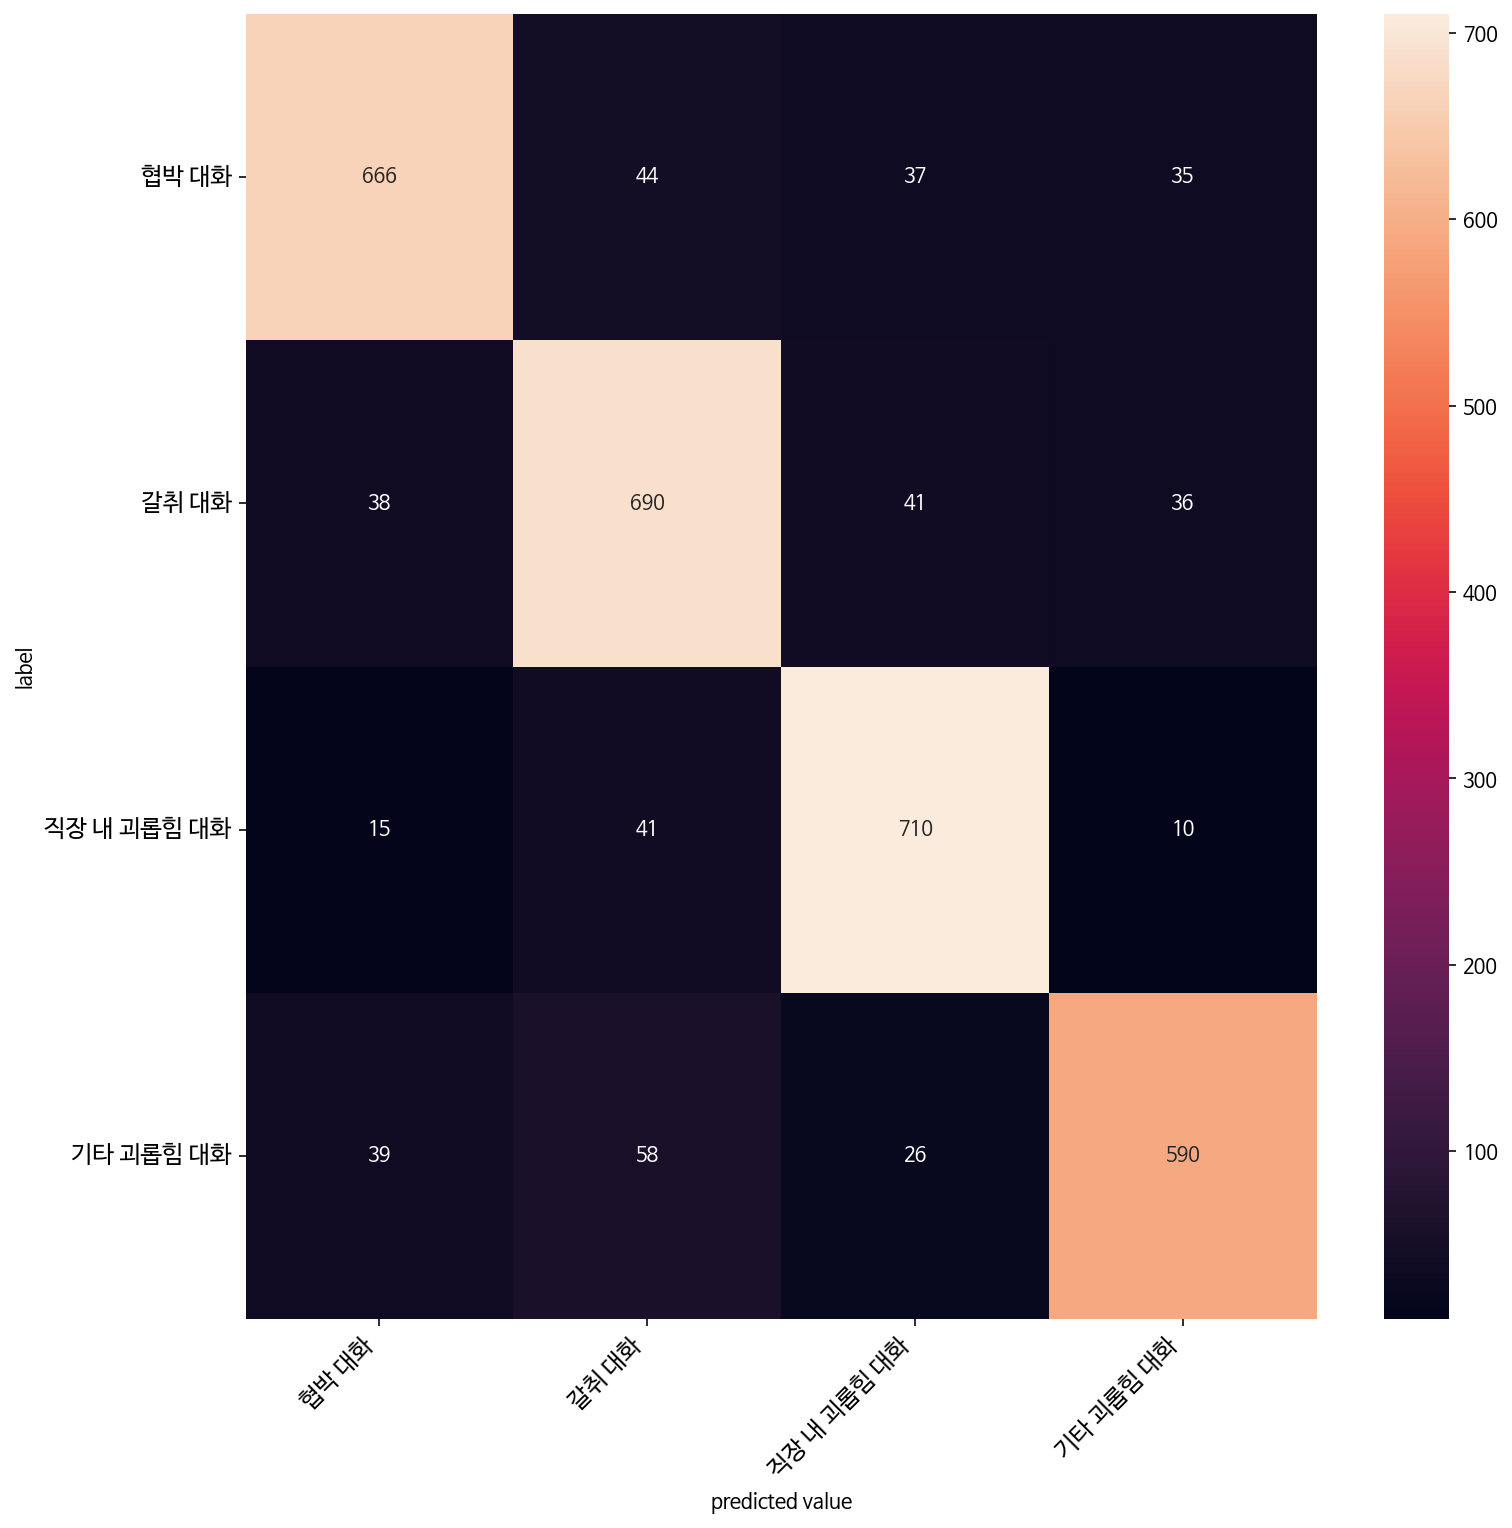

In [86]:
graph_confusion_matrix(svc, x_train, y_train, class_names)

In [99]:
pos

['VV', 'VV+EC', 'VV+EF', 'NNG', 'NP', 'MAG']

In [100]:
print(classification_report(y_train, svc.predict(x_train), zero_division=0))

              precision    recall  f1-score   support

       갈취 대화       0.88      0.86      0.87       794
   기타 괴롭힘 대화       0.85      0.86      0.86       790
 직장 내 괴롭힘 대화       0.88      0.93      0.91       772
       협박 대화       0.88      0.84      0.86       720

    accuracy                           0.87      3076
   macro avg       0.87      0.87      0.87      3076
weighted avg       0.87      0.87      0.87      3076



- 동사, 동사+연결어미, 동사+종결어미, 일반명사, 일반부사, 대명사 추출
- 앞서 3개 품사만 추출했을 때보다 아주 약간 나아졌으나, 거의 비슷한 수준
- 품사 선택은 그렇게 큰 영향이 없는 것 같다.

# test, submission

### test

In [32]:
test_data = pd.read_json('data/test.json', orient='index')

test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, t_000 to t_499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
dtypes: object(1)
memory usage: 6.2+ KB


In [174]:
test_data[test_data["text"].duplicated() == True]

,text
t_306,찬호야 꼬추 한번만 보자 그래 잘 컸나 보자 하지마 선생님한테 다 이를 거야 일러라...


### submission

In [33]:
submission_data = []

for file_name, row in test_data.iterrows():
    text = row['text']
    _input = vector.transform([text])
    predicted = svc.predict(_input)[0]
    
    submission_data.append({
        'file_name': file_name,
        'class': predicted
    })

In [34]:
submission_data = pd.DataFrame(submission_data)

submission_data.head()

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_004,3
4,t_005,0


<AxesSubplot:>

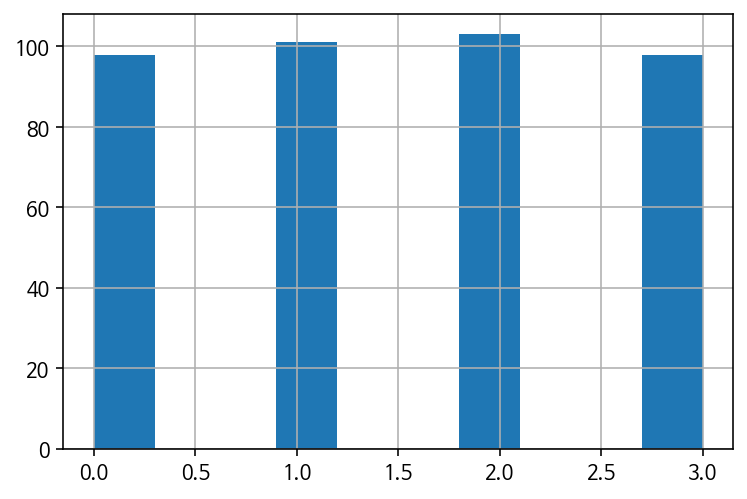

In [35]:
submission_data["class"].hist()

In [29]:
submission_data.to_csv('submission.csv', index=False)

# model: deeplearning

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
import numpy as np

In [19]:
from gensim.models import Word2Vec

## preprocessing

In [150]:
train_data.loc[:, "preprocessed"] = train_data["conversation"].apply(preprocess_document)

In [151]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3846 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class         3846 non-null   int64 
 1   conversation  3846 non-null   object
 2   preprocessed  3846 non-null   object
dtypes: int64(1), object(2)
memory usage: 120.2+ KB


In [152]:
train_data.head()

,class,conversation,preprocessed
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


In [388]:
save_var(train_data, f"{prefix}_train_data_{postfix}")

### tokenize

In [64]:
def read_tokenizer(tokenizer, token_pos, corpus):
    results = []
    for sentence in corpus:
        token_list = tokenizer.pos(sentence)
        result = []
        for word in token_list:
            if word[1] in token_pos:
                result.append((word[0]))
        results.append(' '.join(result))
    return results

In [153]:
import random
rand_index = random.randint(0, train_data.shape[0])

# text_sample = train_data['preprocessed'].sample(1).values[0]
text_sample = train_data['preprocessed'].iloc[rand_index]

print(f"{text_sample} - {train_data['class'].iloc[rand_index]}")
print(mecab.pos(text_sample))

이번 신입 좀 맘에 안들어요 그치 김대리도 별로지 회사에 밝은 옷 하고는 그니까요 오냐오냐하니까 자기가 뭐라도 된줄알고 안녕하십니까 외근 다녀왔습니다 응그래 근데 자기 셀럽이야 앗 아뇨 왜그러시는지 좀 눈에 거슬리네 넵 아니 자기 옷이 좀 밝고 화려해서 눈에 띄고 그러네 네 무슨 문제라도 아냐이쁘다고 그 시간에 일하면 더 좋지만 - 2
[('이번', 'NNG'), ('신입', 'NNG'), ('좀', 'MAG'), ('맘', 'NNG'), ('에', 'JKB'), ('안', 'MAG'), ('들', 'VV'), ('어요', 'EF'), ('그치', 'IC'), ('김', 'NNP'), ('대리', 'NNG'), ('도', 'JX'), ('별로', 'MAG'), ('지', 'NNG'), ('회사', 'NNG'), ('에', 'JKB'), ('밝', 'VA'), ('은', 'ETM'), ('옷', 'NNG'), ('하', 'VV'), ('고', 'EC'), ('는', 'JX'), ('그니까', 'MAJ'), ('요', 'JX'), ('오냐오냐', 'IC'), ('하', 'VV'), ('니까', 'EC'), ('자기', 'NP'), ('가', 'JKS'), ('뭐', 'NP'), ('라도', 'VCP+EC'), ('된', 'VV+ETM'), ('줄', 'NNB'), ('알', 'VV'), ('고', 'EC'), ('안녕', 'NNG'), ('하', 'XSV'), ('십니까', 'EP+EF'), ('외근', 'NNG'), ('다녀왔', 'VV+EP'), ('습니다', 'EF'), ('응', 'IC'), ('그래', 'IC'), ('근데', 'MAJ'), ('자기', 'NP'), ('셀', 'VV+ETM'), ('럽', 'NNP'), ('이', 'VCP'), ('야', 'EF'), ('앗', 'IC'), ('아뇨', 'IC'), ('왜', 'MAG'), ('그러', 'VV'), ('시', 'EP'), ('는지', 'EC'), ('좀', 'MAG'), ('눈', 'NNG

In [161]:
res = train_data["preprocessed"][train_data['class'] == 0].sample(3)
print(res.values)

['어이 세치기하지 말고 뒤로 가 어따대고 반말이야 세치기한 주제에 말이 많네 왜 반말에 삿대질이야 저 손가락을 부러뜨릴까보다 이사람 말하는 거 보소 세치기 했으면 뒤로 가쇼 패버리기 전에 사과하기 전엔 꼼짝도 못 해 사과는 무슨 어디서 칼 들고 오기 전에 뒤로 가 반말에 협박 사과해 이사람아'
 '이 약이 뭔 거 같아 뭔데요 뭐긴 뭐야 네 엄마 저승길 보내주는 약이지 네 그게 무슨 네 엄마 지금 저 빌딩에 있지 그리고 저 빌딩에선 시음회가 열리고 있고 그게 무슨 이미 인력은 다 배치해놨어 저 음료를 마시면 네 엄마는 아 안 돼 네 엄마 살리고 싶으면 내가 시키는 대로 해 멈춰요 알겠으니까 그만하라고 내가 시키는 대로 해 알겠다고요 제발 그만'
 '지금 남자친구랑 헤어지고 나한테 돌아와 내가 왜 싫어 지금 남자친구랑 안헤어져 지금 여자친구 정리하고 나한테 돌아오지 않으면 너가 그렇게 좋아하는 남자친구 하루아침에 교통사고로 죽을 고비를 겪게 해줄게 어떻게 그렇게 무서운 말을 해 무서우면 나한테 돌아와 너한테 절대 안가 그러면 너 남자친구 죽을지도 몰라 정신차려 어떻게 사람을 죽일 생각을 해 나 제정신이야 나한테 돌아오라고 싫어']


In [159]:
res = train_data["preprocessed"][train_data['class'] == 1].sample(3)
print(res.values)

['안녕 오랜만이다 요즘 뭐하고지내 아 오랜만에 연락했네 나야 잘 지내지 너는 어때 나도 잘지내지 우리 예전에 맛집갔을때 생각나 그때 맛있었잖아 그래그래 맞아 생각나 거기 진짜 맛있었지 그래서 말인데 우리 담에 거기 또 가자 좋아 언제 한번가자 아 그리고 나 할말이 있어 뭔뎅 나 돈좀 빌려주라 갑자기 무슨일인데 급한일이 생겨서 돈이 필요해 빌려줄수있어 아 나도 지금 힘든데 친구 사이에 그정도도 못빌려줘 니가 그러고 친구야 실망이다 안빌려주면 평생 나 볼 생각하지마 얼마나 필요한데 알았어 이번만이야'
 '야 저번에 내 셔츠에 오징어짬뽕 쏟아서 세탁비 100만원 가져오라했지 어딨어 뭔 셔츠가 100만원이야 싯팔 뭐 걍 손세탁하면 되겠구만 뒤질래 지갑 꺼내 나 현금 없음 카드 가져갈거야 빙시나 세탁 줄테니까 좀만 해주셈 그럼 80 아 그것도 비싼데 싯팔'
 '철수야 내일까지 3만원가져와라 나 이제 더이상 부모님께 돈 못받아 그럼 몸으로 때우자 그만해 제발 왜이래 학교생활하기싫어 내가 뭘잘못했다고 많이가져다줫잔아 넌 존재자체가 거슬려 맞기싫으면 돈가져와 더괴롭히면 신고할거야 해봐 그럼 죽여버릴테니 미안해제발']


In [162]:
res = train_data["preprocessed"][train_data['class'] == 2].sample(3)
print(res.values)

['오늘까지 내가 보고서 작성하라 했지 네 한다고 했는데 근데 왜 안했어 너 돌대가리야 말귀 못알아들어 근데 할일이 너무 많아서 할일이 많아 아직도 정신 못차렸지 잘못했습니다 너 오늘 내가 시킨거 다할때까지 퇴근할 생각하지 말어 알았어 네 알겠습니다 이게 기합이 빠져가지고 어떻게 저딴게 우리 회사를 들어왔지 죄송합니다'
 '길동씨 오늘 회식 올꺼지 이번엔 빠지면 안돼 아 부장님 오늘 제가 일이 있어서 아니 길동씨는 어떻게 회식때마다 일이있나 어제 말씀해주셔서 이미 잡은 약속을 깰수가 없었어요 길동씨는 항상 그래 매번 회식때마다 피하고 회식도 일의 일부라는걸 모르나 죄송합니다 죄송하면 오늘 회식 참석해 약속이 중요한가 회사일이 중요하지 오늘 부모님모시고 가기로 한거라서요 자네 자꾸 이런식으로 나오면 나도 자네 못봐줘 한다한다하니까 매번 이런식이면 회사를 때려치우든가 죄송합니다'
 '씨 내일까지 이거 다해오세요 이걸 하루만에요 네 못 하겠으면 그만두시면 됩니다 혹시나 다른 사원들에게 도와달라고 하시면 안됩니다 저 도저히 이건 하루만에 못 하는데 적어도 이틀 주시면 내일까지 해오시고 오후에 잠시 미팅있는데 외근다녀오십시오 저 외근까지 다녀오면 진짜 못 할것같습니다 상사가 하라면 하는겁니다 밤을 새든 알아서 해오세요']


In [157]:
res = train_data["preprocessed"][train_data['class'] == 3].sample(3)
print(res.values)

['학원선생님 우리아이가 성적이 안오르니 더이상 못보내겠어요 어머니 제가 우리 철수는 성의껏 가르쳤는데 아직 기초가 부족하니 이번 방학까지 더 신경쓰겠습니다 뭐래요 선생님께 6개월 보냈으면 벌써 몇등은 올라야하는거 아니예요 우리 철수가 이 부분 기초가 부족해서 개념부터 다시 잡느라고 시간이 좀더 걸립니 결국 우리애 탓이라는거잖아 선생님 실력이 없으면서 뭐 애탓을 하고 그래요 어머니 그게 아니라 정 그러시면 다음주까지 정리하겠습니다 2달 수업비 연체되신거 정리해주시고 교채챙겨보내겠습니다 이 선생 안되겠구만 똑바로 가르쳐주지도 않고 돈부터 밝히고 성적이 그대로인데 학원비를 내가 왜 내 어머니 그건 아니죠 그딴식으로 애들가지고 장사하면 내가 인터넷에 제대로 글 올릴거야 애들장사 앞으로 더하려면 돈밝히지마요'
 '아이고 동네 사람들 며느리가 시어머니 잡네잡아 어머니 정말 왜그러세요 나 약먹는다 그약이 독약인지 내가 어떻게아냐 이약안먹으면 증상이 더 안좋아져요 나는 멀쩡하다 어머니 제발요 어머니때문에 온 가족이 힘들어요 아이고 이년이 이제 나 죽으라고 제사지내네 어머니 왜 그러세요 제발 정신차리세요 동네 사람들 며느리가 시어머니 약먹여 죽여요 죽여 그런거 아니에요 제발'
 '여보세요 거기 청소업체죠 네 말씀하세요 아니 일처리를 이렇게 하고 가면 어떻게 합니까 무슨 말씀이세요 깔끔하게 뒷정리도 하고 갔는데요 짜증나게하네 베란다에 있는건 뭐죠 그거는 저희가 가지고온게 아닙니다 청소부면 이런것도 가지고 가야 하는거 아니에요 그건 저희의 의무가 아닙니다 사모님 이러니 청소부나 하고 있지 돈 입금 못합니다 사모님 그래도 이건 아닌거 같아요']


In [469]:
check_index = []

In [470]:
check_index.append(rand_index)

In [472]:
check_index

[2592]

In [471]:
save_var(check_index, "check_index")

In [65]:
token_pos = read_tokenizer(mecab, ['VV', 'VV+EC', 'NNG'], train_data["preprocessed"])

In [168]:
print(train_data["preprocessed"].loc[2592])
print(train_data["class"].loc[2592])

당장 세금 안내면 이빨 뺀치로 뽑아버리겠어 아 몰라 귀찮아 당신 작년에도 안내고 올해도 안내서 가산금 붙었어 어쩔꺼야 지금 집에 왔는데 어쩌라고 퀴찮아 나 인생에서 그딴거 낸 적 없다 나라에서 내라는 건데 귀찮아도 내야지 얻어맞고싶니 지금 못내고 나중에라도 내면 될꺼아냐 나중에 언제 계좌번호 찍고 빨리 기한내 안내면 망치로 머리 때린다
0


In [66]:
print(token_pos[:10])

['스스로 죽여 애원 죽 죽 사건 휘말리 죽여 선택 죽 가족 죽여 선택 선택 한다면 가족 죽여 선택 하 도와 죽여 도와', '길동 경찰서 마트 폭발물 설치 들 얘기 장난 전화 걸 마시 마트 폭발물 터지 죽 장난 전화 업무 방해죄 해당 판단 달려 길동 경찰서 폭발물 터지 선생 진정 이야기 경고 말', '알 남자 해 놀리 키 돼 군대 가 보태 난쟁이 장가가 하 희망 가져 이상 하 키 수술 엄마 해 나람 해 키 살 괴롭히', '말 오 일 옷 돈 돈 뒤져서 나오 죽 피시방 콜 콜 마지막 기회', '날 회사 선크림 파 손등 발라 그래도 선크림 필요 알아보 발라 발라 성분 성분 피부 맞 피부 이번 연구 피부 파 돈 내 발라보 돈 내 팔 발라 권유 사 강매 갈취 사 된다고 말 모르 사 사 사람 갈취 화딱지', '이틀 뒤 가 음식점 예약 해 저녁 음식점 남자 친구 부모 인사 드리 예약 해 팀장 월 말 프로젝트 정신없 사회 생활 해 티 내 프로젝트 하 해 상사 보이 해야지 하 팀 프로젝트 이번 말 이상 이번 심부름 말 실수 말씀 예약 해 이러 하 욕먹 알 하 알', '손님 아이스커피 잔 아이스커피 아가씨 아스 날 아이스 시키 기억 아가씨 손 주문 기억 아가씨 유 도리 굴 주문 받 하 되 도리', '경비 아저씨 내차 경고장 사 내차 모르 경고장 붙여 입주민 주차 자리 통로 주차 입주민 항의 대 자리 차 얼마 줄 알 수차례 인터폰 경고장 몇일 인지 아파트 규약 맞춰 본드 붙이 원상 복구 세차 관리비 월급 받 주제 붙 되 가요 말씀 이름 가 끝', '할인 확인 시 할인 손 고객 고객 차별 운영 점장 불러오 손 점장 해결 점장 불러와 진정 해', '세금 계산서 보내 메일 수치 해 먹 업체 회사 비밀 해 성의 표시 정도 생각 해 먹 정도 되 사장 말 건 국세청 걸리 알 기한']


In [375]:
save_var(token_pos, f"{prefix}_token_pos_{postfix}")

In [179]:
tokenized_texts = [' '.join(mecab.morphs(text)) for text in train_data["preprocessed"]]

In [323]:
tokenized_texts[2]

'너 되게 귀여운 거 알 지 나 보다 작 은 남자 는 첨 봤 어 그만 해 니 들 놀리 는 거 재미없 어 지영 아 너 가 키 160 이 지 그럼 재 는 160 도 안 돼 는 거 네 너 군대 도 안 가 고 좋 겠 다 니 들 이 나 작 은 데 보태 준 거 있 냐 난쟁이 들 도 장가가 고 하 던데 너 도 희망 을 가져 봐 더 이상 하 지 마 라 그 키 크 는 수술 도 있 대잖아 니 네 엄마 는 그거 안 해 주 디 나람 해 줬 어 저 키 로 어찌 살 아 제발 그만 괴롭히 라고'

### padding sequences

In [29]:
def get_padded_sequences(corpus, maxlen=223):
    # tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer = Tokenizer(num_words=100_000)
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
    return tokenizer, padded_sequences

In [67]:
tokenizer, padded_sequences = get_padded_sequences(token_pos)

In [30]:
labels_categorical = to_categorical(train_data["class"], num_classes=4)

In [376]:
save_var(labels_categorical, f"{prefix}_labels_categorical_{postfix}")

### w2v

In [349]:
tokenized = [mecab.morphs(sentence) for sentence in train_data["preprocessed"]]

In [331]:
tokenized = [sentence.split() for sentence in train_data["preprocessed"]]

In [350]:
w2v = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [184]:
model.save("w2v_preprocessed")

INFO:tensorflow:Assets written to: w2v_preprocessed/assets


INFO:tensorflow:Assets written to: w2v_preprocessed/assets


In [139]:
w2v = Word2Vec.load("word2vec_tokenized")

In [101]:
w2v.wv.most_similar('갈취')

[('난리', 0.9296451807022095),
 ('어른', 0.9228559732437134),
 ('헛소문', 0.9176976084709167),
 ('홍당무', 0.9097967743873596),
 ('폭로', 0.9091793298721313),
 ('질', 0.9087285995483398),
 ('베', 0.9079527258872986),
 ('전혀', 0.9079012870788574),
 ('드립', 0.9077075123786926),
 ('그리', 0.9069563150405884)]

In [352]:
w2v.corpus_total_words

405398

### embedding matrix

In [32]:
def get_embedding_matrix(corpus, tokenizer, model_w2v, embedding_dim=300):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in model_w2v.wv:
            embedding_matrix[i] = model_w2v.wv[word]
    return embedding_matrix

In [122]:
embedding_matrix = get_embedding_matrix(token_pos, 
                                        tokenizer=tokenizer, 
                                        model_w2v=w2v, 
                                        embedding_dim=100)

In [123]:
embedding_matrix.shape

(8059, 100)

In [369]:
prefix = 't01'
postfix = 'pos_03'

In [378]:
save_var(embedding_matrix, f"{prefix}_embedding_matrix_{postfix}")

In [120]:
input_length = padded_sequences.shape[1]
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

### model: GRU

In [356]:
def build_model(input_length, vocab_size, embedding_dim, embedding_matrix):
    inputs = layers.Input(shape=(input_length,))
#     x = layers.Embedding(vocab_size, embedding_dim, input_length=input_length)(inputs)
    x = tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                trainable=False)(inputs)
    x = layers.GRU(512)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [121]:
model = build_model(input_length, vocab_size, embedding_dim, embedding_matrix)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [118]:
del model

#### fit

In [364]:
history = model.fit(
    padded_sequences, labels_categorical,
    epochs=50,
    batch_size=4, 
#     validation_data=(x_val, y_val)
    validation_split=0.2,
)

Epoch 1/50
769/769 [==============================] - 8s 9ms/step - loss: 1.3877 - accuracy: 0.2539 - val_loss: 1.3883 - val_accuracy: 0.2312
Epoch 2/50
769/769 [==============================] - 7s 9ms/step - loss: 1.3577 - accuracy: 0.3309 - val_loss: 1.0856 - val_accuracy: 0.5143
Epoch 3/50
769/769 [==============================] - 7s 9ms/step - loss: 0.8659 - accuracy: 0.6547 - val_loss: 0.8472 - val_accuracy: 0.6766
Epoch 4/50
769/769 [==============================] - 7s 9ms/step - loss: 0.7561 - accuracy: 0.7129 - val_loss: 0.7907 - val_accuracy: 0.6857
Epoch 5/50
769/769 [==============================] - 7s 9ms/step - loss: 0.6239 - accuracy: 0.7617 - val_loss: 0.6369 - val_accuracy: 0.7519
Epoch 6/50
769/769 [==============================] - 7s 9ms/step - loss: 0.7125 - accuracy: 0.7253 - val_loss: 0.7387 - val_accuracy: 0.7117
Epoch 7/50
769/769 [==============================] - 7s 9ms/step - loss: 0.6240 - accuracy: 0.7614 - val_loss: 0.6311 - val_accuracy: 0.7727
Epoch 

#### history

In [380]:
histories = {}

In [384]:
histories[prefix] = history.history

In [385]:
histories.keys()

dict_keys(['t01'])

In [387]:
save_var(history.history, f"{prefix}_history_{postfix}")

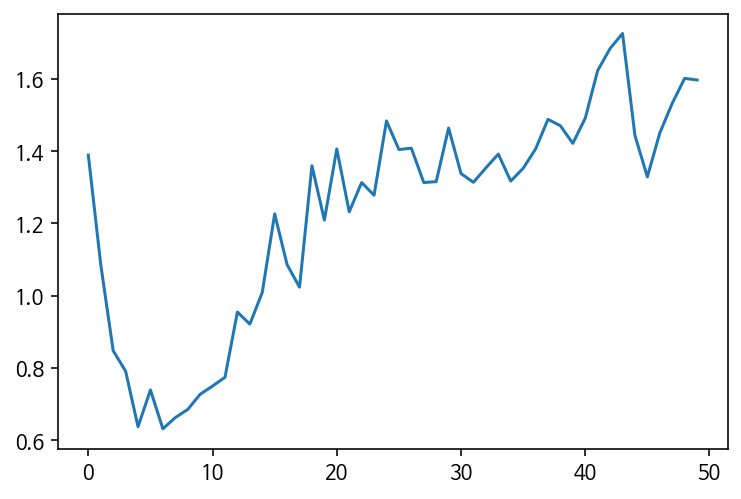

In [365]:
plt.plot(history.history['val_loss'])

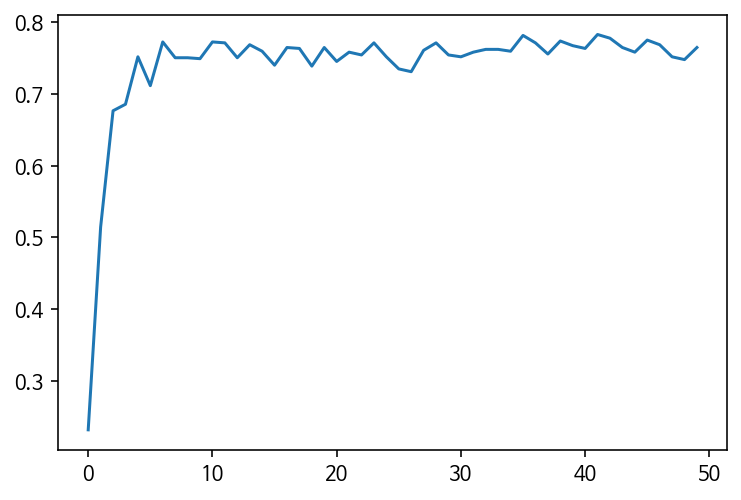

In [366]:
plt.plot(history.history['val_accuracy'])

In [367]:
model.save("gru_512_pos_3.h5")

In [368]:
model.save_weights("gru_512_pos_3")

### model: transformer

In [33]:
tokenizer, padded_sequences = get_padded_sequences(train_data["preprocessed"])

In [45]:
w2v = Word2Vec.load("./word2vec_tokenized")

In [68]:
embedding_matrix = get_embedding_matrix(
#     train_data["preprocessed"], 
    token_pos,
    tokenizer=tokenizer,
    model_w2v=w2v,
    embedding_dim=100)

In [69]:
input_length = padded_sequences.shape[1]
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

In [46]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [47]:
def build_model(input_shape, 
                num_classes, 
                vocab_size, 
                embed_dim=64, 
                head_size=128, 
                num_heads=4, 
                ff_dim=128, 
                dropout=0.4):
    
    inputs = layers.Input(shape=(input_shape,))
    embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    
    x = transformer_encoder(embedding_layer, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
    
    return model

In [124]:
num_classes = 4  # Number of output classes

model = build_model(input_length, num_classes, vocab_size)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 223)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 223, 64)      515776      input_6[0][0]                    
__________________________________________________________________________________________________
layer_normalization_6 (LayerNor (None, 223, 64)      128         embedding_3[0][0]                
__________________________________________________________________________________________________
multi_head_attention_3 (MultiHe (None, 223, 64)      132672      layer_normalization_6[0][0]      
                                                                 layer_normalization_6[0][0]

In [125]:
history = model.fit(
    padded_sequences, 
    labels_categorical, 
    epochs=5, 
    batch_size=4,
    validation_split=0.2)

Epoch 1/5
769/769 [==============================] - 6s 7ms/step - loss: 1.2028 - accuracy: 0.4496 - val_loss: 0.6567 - val_accuracy: 0.7610
Epoch 2/5
769/769 [==============================] - 5s 7ms/step - loss: 0.5924 - accuracy: 0.7991 - val_loss: 0.6325 - val_accuracy: 0.8130
Epoch 3/5
769/769 [==============================] - 5s 7ms/step - loss: 0.3497 - accuracy: 0.8917 - val_loss: 0.7214 - val_accuracy: 0.8156
Epoch 4/5
769/769 [==============================] - 5s 7ms/step - loss: 0.2028 - accuracy: 0.9386 - val_loss: 0.8389 - val_accuracy: 0.8143
Epoch 5/5
769/769 [==============================] - 5s 7ms/step - loss: 0.1271 - accuracy: 0.9652 - val_loss: 1.0430 - val_accuracy: 0.8039


In [72]:
prefix = 't04'
postfix = 'token_pos3'

In [73]:
save_var(history.history, f"{prefix}_history_{postfix}")

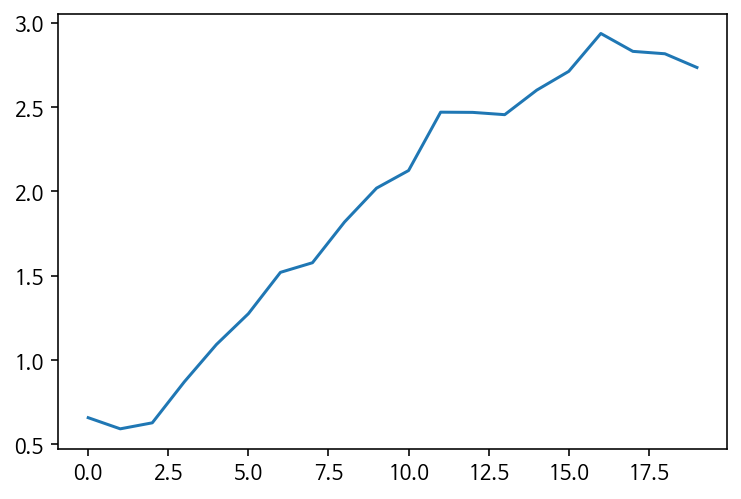

In [74]:
plt.plot(history.history['val_loss'])

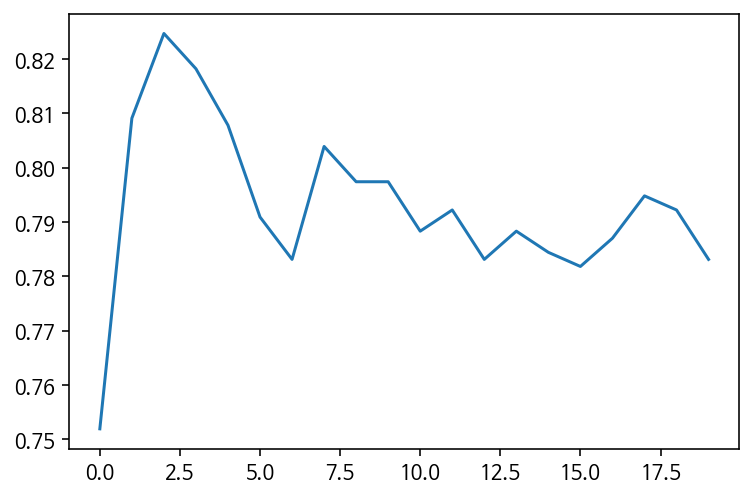

In [75]:
plt.plot(history.history['val_accuracy'])

In [399]:
model.save(f"{prefix}_transformer_{postfix}.h5")

In [76]:
model.save_weights(f"{prefix}_transformer_{postfix}")

In [126]:
pred = model.predict(padded_sequences)

In [127]:
pred_max = [np.argmax(x) for x in pred]

In [128]:
print(classification_report(train_data["class"], pred_max, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       892
           1       0.95      0.95      0.95       973
           2       0.98      0.96      0.97       970
           3       0.93      0.95      0.94      1011

    accuracy                           0.95      3846
   macro avg       0.95      0.95      0.95      3846
weighted avg       0.95      0.95      0.95      3846



In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def graph_confusion_matrix(model, pred, labels, classes_name):
    
    df_cm = pd.DataFrame(confusion_matrix(labels, pred), index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    plt.show()
    

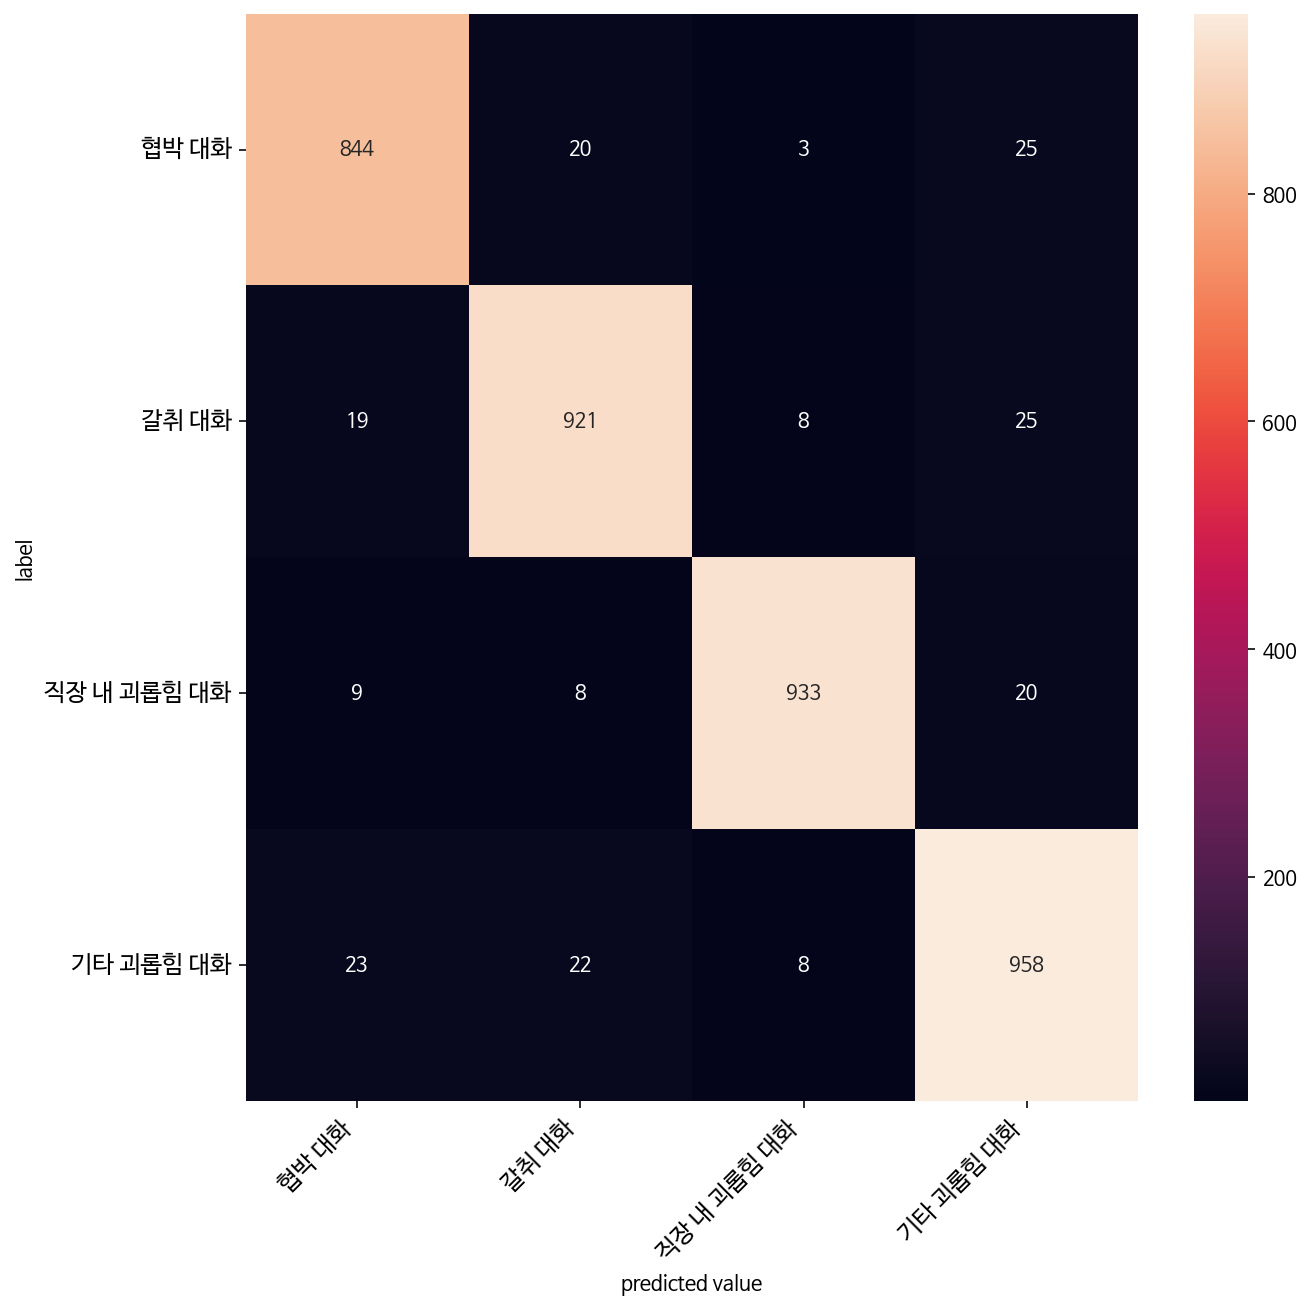

In [129]:
graph_confusion_matrix(model, pred_max, train_data["class"], class_names)

# test, submission

### test

In [82]:
test_data = pd.read_json('data/test.json', orient='index')

test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [102]:
test_data.shape

(400, 2)

In [117]:
rand_index = random.randint(0, test_data.shape[0])

res = test_data["text"].iloc[rand_index]
print(rand_index, res)

sample_tokenizer, sample_inputs = get_padded_sequences([res])
pred_sample = model.predict(sample_inputs)
pred_max = np.argmax(pred_sample)
print(pred_max)

107 저 그만좀 하시면 안될까요 야 니가 만져도 된다고 거의 이미 합의가 된상태야 만약 경찰한테 신고 하면 그날 니 맞아 죽는줄알아라 네 알겠습니다. 야 안되겠어 그냥 살려두면 신고할게 뻔해 그래 안되겠다  살려주세요. 진짜 다시 경고 한다. 신고 하면 죽는다.
2


In [433]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, t_000 to t_499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
dtypes: object(1)
memory usage: 6.2+ KB


In [443]:
test_data.keys()

Index(['text', 'preprocessed'], dtype='object')

In [434]:
test_data[test_data["text"].duplicated() == True]

,text
t_306,찬호야 꼬추 한번만 보자 그래 잘 컸나 보자 하지마 선생님한테 다 이를 거야 일러라...


### preprocessing

In [84]:
test_data.loc[:, "preprocessed"] = test_data["text"].apply(preprocess_document)

In [85]:
save_var(test_data, f"{prefix}_test_data_{postfix}")

In [130]:
test_tokenizer, test_inputs = get_padded_sequences(test_data["preprocessed"])

In [131]:
test_pred = model.predict(test_inputs)

In [132]:
pred_max = [np.argmax(x) for x in test_pred]

(array([117.,   0.,   0.,  95.,   0.,   0.,  68.,   0.,   0., 120.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

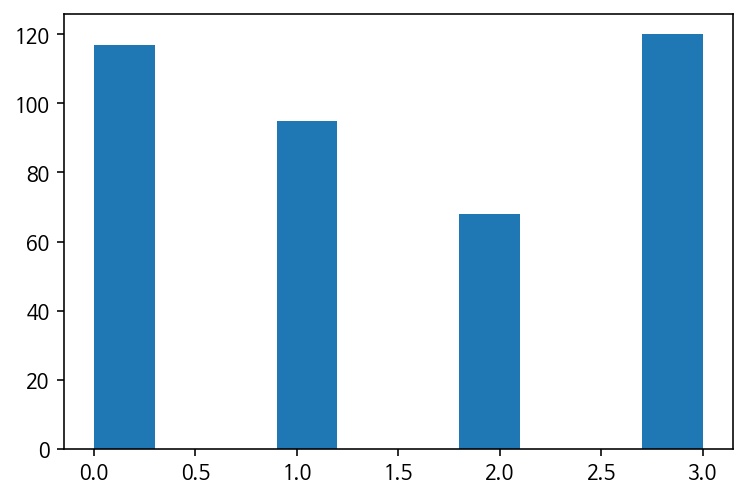

In [133]:
plt.hist(pred_max)

### submission

In [134]:
submission_data = []

for file_name, row in test_data.iterrows():
    submission_data.append({
        'file_name': file_name,
    })

In [135]:
submission_data = pd.DataFrame(submission_data)
submission_data.loc[:, "class"] = pred_max

submission_data.head()

,file_name,class
0,t_000,1
1,t_001,0
2,t_002,3
3,t_004,0
4,t_005,1


In [136]:
submission_data.to_csv('submission.csv', index=False)